#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션3

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 딥러닝 구조의 모델로 분류 모델 생성
    * 최소 4개 이상 모델링 수행
    * 각 모델별 최소 5회 반복수행해서 얻은 성능의 평균으로 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.
* 성능 가이드
    * Accuracy : 0.90 ~ 0.99

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project1 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# path = '/content/drive/MyDrive/project1/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩
     - pandas, numpy,matplotlib,seaborn, joblib, 모델링에 필요한 라이브러리를 로딩합니다.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam

In [4]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [38]:
# 주어진 데이터 셋을 불러오세요.(3개)
train_data = pd.read_csv('./data01_train.csv')
test_data = pd.read_csv('./data01_test.csv')
features = pd.read_csv('./features.csv')

In [39]:
#불필요한 칼럼을 삭제하세요.
drop_columns = ['subject']
train_data = train_data.drop(columns=drop_columns)
test_data = test_data.drop(columns=drop_columns)

#### 2) 기본 정보 조회

In [7]:
#전체 데이터의 행,열 개수 확인
print(train_data.shape)
print(test_data.shape)  

(5881, 562)
(1471, 562)


In [8]:
#전체 데이터의 상위 5개 행 확인
train_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [9]:
#전체 데이터의 수치형 변수 분포 확인
all_columns = train_data.columns.tolist()
num_columns = train_data._get_numeric_data().columns.tolist()
cat_columns = list(set(all_columns) - set(num_columns))

print(f'모든 컬럼 \n{all_columns}\n')
print(f'수치형 컬럼 \n{num_columns}\n')
print(f'범주형 컬럼 \n{cat_columns}\n\n')

모든 컬럼 
['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X', 'tBodyAcc-max()-Y', 'tBodyAcc-max()-Z', 'tBodyAcc-min()-X', 'tBodyAcc-min()-Y', 'tBodyAcc-min()-Z', 'tBodyAcc-sma()', 'tBodyAcc-energy()-X', 'tBodyAcc-energy()-Y', 'tBodyAcc-energy()-Z', 'tBodyAcc-iqr()-X', 'tBodyAcc-iqr()-Y', 'tBodyAcc-iqr()-Z', 'tBodyAcc-entropy()-X', 'tBodyAcc-entropy()-Y', 'tBodyAcc-entropy()-Z', 'tBodyAcc-arCoeff()-X,1', 'tBodyAcc-arCoeff()-X,2', 'tBodyAcc-arCoeff()-X,3', 'tBodyAcc-arCoeff()-X,4', 'tBodyAcc-arCoeff()-Y,1', 'tBodyAcc-arCoeff()-Y,2', 'tBodyAcc-arCoeff()-Y,3', 'tBodyAcc-arCoeff()-Y,4', 'tBodyAcc-arCoeff()-Z,1', 'tBodyAcc-arCoeff()-Z,2', 'tBodyAcc-arCoeff()-Z,3', 'tBodyAcc-arCoeff()-Z,4', 'tBodyAcc-correlation()-X,Y', 'tBodyAcc-correlation()-X,Z', 'tBodyAcc-correlation()-Y,Z', 'tGravityAcc-mean()-X', 'tGravityAcc-mean()-Y', 'tGravityAcc-mean()-

In [11]:
#전체 데이터의 모든 변수 확인
train_data.describe(include='all').T
train_data.isnull().sum()

tBodyAcc-mean()-X                       0
tBodyAcc-mean()-Y                       0
tBodyAcc-mean()-Z                       0
tBodyAcc-std()-X                        0
tBodyAcc-std()-Y                        0
                                       ..
angle(tBodyGyroJerkMean,gravityMean)    0
angle(X,gravityMean)                    0
angle(Y,gravityMean)                    0
angle(Z,gravityMean)                    0
Activity                                0
Length: 562, dtype: int64

## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [40]:
# 데이터 분할을 합니다.
X = train_data.drop(columns=['Activity'])
y1 = train_data['Activity']
X_test = test_data.drop(columns=['Activity'])
y1_test = test_data['Activity'] 


### (2) Y 전처리
* integer encoding : LabelEncoder
* (필요시) one-hot encoding

In [41]:
# 정수 인코딩 변환(LabelEncoder)
le = LabelEncoder()
y1 = le.fit_transform(y1)
y1_test = le.transform(y1_test) 


In [15]:
# 기존 레이블 저장
joblib.dump(le, 'labelencoder.pkl')  #라벨인코더 저장
# le = joblib.load('labelencoder.pkl')  #라벨인코더 불러오기

['labelencoder.pkl']

### (3) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [53]:
#데이터 분할 진행(train:val = 8:2 혹은 7:3 권장)
x_train, X_val, y1_train, y1_val = train_test_split(X, y1, test_size=0.2, random_state=1, stratify=y1)
x_train.shape, X_val.shape, y1_train.shape, y1_val.shape

((4704, 561), (1177, 561), (4704,), (1177,))

### (4) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [54]:
#스케일링 방식을 선택해서 스케일링을 진행합니다.
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
X_val = scaler.transform(X_val)

## **3. 기본 모델링**



* 세부 요구사항
    - 모델1 : Base line 모델
        * Hidden Layer 없이 모델 생성
    - 모델2 : 복잡한 모델 생성
        * 최소 5개 이상의 은닉층을 추가한 모델
    - 모델3 ~ n : 튜닝 모델
        * 학습률, epoch 등 조정
        * 모델2에 과적합을 방지하기 위한 규제 기법 추가
        * Accuracy 최대화 시키는 모델 생성하기
    - (옵션) 각 모델은 최소 5번 반복수행해서 얻은 성능의 평균값을 기록

### (1) 모델1 : Hidden Layer 없이 모델 생성

In [60]:
# 모델 설계
clear_session()

nfeatures = x_train.shape[1]

model1 = Sequential([
    Input(shape=(nfeatures,)),
    Dense(6, activation='softmax')
])

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6)              │         3,372 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,372 (13.17 KB)

 Trainable params: 3,372 (13.17 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
# 컴파일 및 학습
model1.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

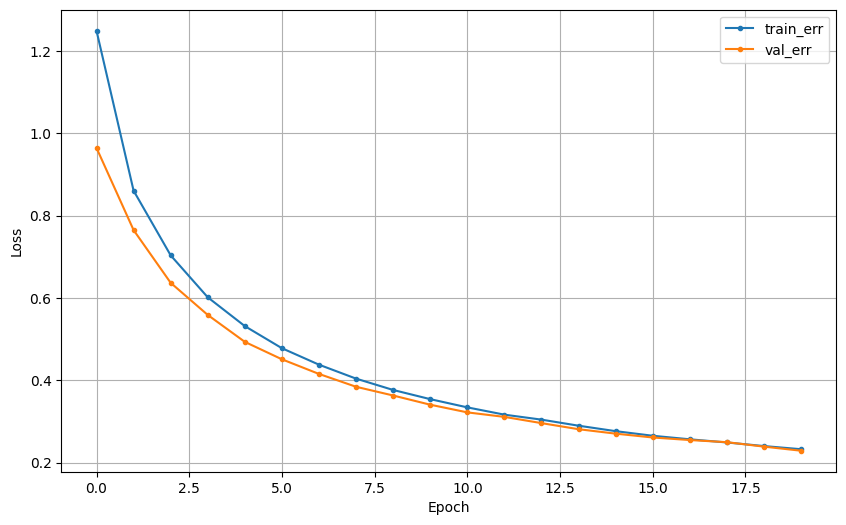

In [62]:
# 학습곡선
history1 = model1.fit(x_train, y1_train, verbose=0,epochs=20, validation_split=0.2, batch_size=64)

dl_history_plot(history1.history)

In [63]:
# 예측 및 평가
y1_pred = model1.predict(X_val)
y1_pred_classes = np.argmax(y1_pred, axis=1)

print(classification_report(y1_val, y1_pred_classes))   
# from google.colab import drive

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       223
           1       0.88      0.82      0.85       206
           2       0.85      0.89      0.87       218
           3       0.97      0.98      0.98       200
           4       0.97      0.96      0.97       158
           5       0.96      0.95      0.96       172

    accuracy                           0.93      1177
   macro avg       0.94      0.94      0.94      1177
weighted avg       0.93      0.93      0.93      1177



In [ ]:
#(옵션) 모델1번을 최소 5번 반복수행해서 얻은 성능의 평균값을 기록해보자!
# precision 80점대에서 반복 실행 결과 99에 수렴

### (2) 모델2 : 최소 5개 이상의 은닉층을 추가한 모델

In [52]:
# 모델 설계
clear_session()
nfeatures = x_train.shape[1]
model2 = Sequential([Input(shape=(nfeatures,)),
                    Dense(128, activation='relu'),
                    Dense(96, activation='relu'),
                    Dense(48, activation='relu'),
                    Dense(24, activation='relu'),
                    Dense(12, activation='relu'),
                    Dense(6, activation='softmax')])

model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        71,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 48)             │         4,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 24)             │         1,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 12)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │            78 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,530 (353.63 KB)

 Trainable params: 90,530 (353.63 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
# 컴파일 및 학습
model2.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist = model2.fit(x_train, y1_train, verbose=0, epochs=50, validation_split=0.2, batch_size=64)

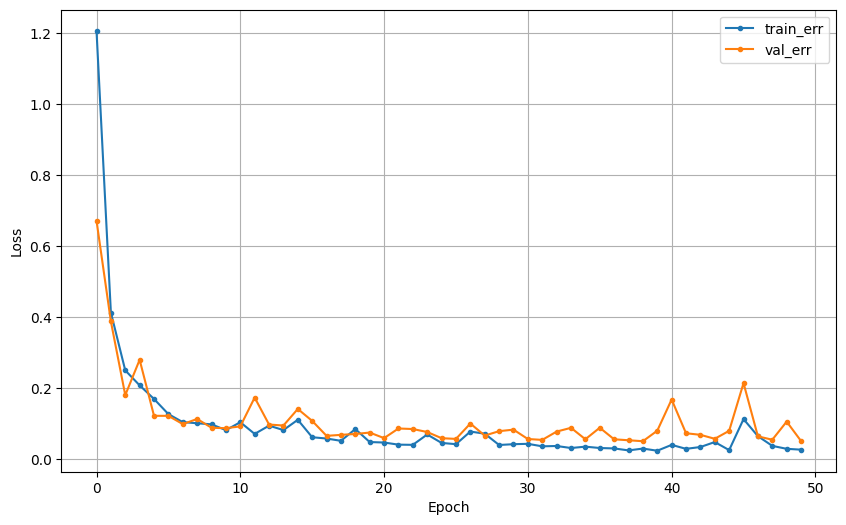

In [66]:
# 학습곡선
dl_history_plot(hist.history)

In [67]:
# 예측 및 평가
y1_pred = model2.predict(X_val)
y1_pred_classes = np.argmax(y1_pred, axis=1)
print(classification_report(y1_val, y1_pred_classes))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       223
           1       0.97      0.96      0.96       206
           2       0.97      0.97      0.97       218
           3       0.99      0.99      0.99       200
           4       0.98      1.00      0.99       158
           5       0.99      0.99      0.99       172

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177



## 4.성능비교

* 세부 요구사항
    - test 데이터에 대한 전처리
    - 각 모델에 대해서 test 데이터로 성능 측정

In [68]:
#전체 데이터 불러오기(test)

# subject 삭제

# x, y 분할
xt = test_data.drop(columns=['Activity'])
yt = test_data['Activity']

# y : 정수인코딩 적용
yt = le.transform(yt)
yt

# x : 스케일링 적용
xt = scaler.fit_transform(xt)

In [70]:
# test 데이터에 대한 성능 측정
yt_test_pred = model2.predict(xt)
yt_test_pred_classes = np.argmax(yt_test_pred, axis=1)  
print(classification_report(yt, yt_test_pred_classes))

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.96      0.89      0.92       254
           2       0.91      0.96      0.93       287
           3       0.99      1.00      1.00       228
           4       1.00      0.99      0.99       195
           5       0.99      1.00      0.99       215

    accuracy                           0.97      1471
   macro avg       0.97      0.97      0.97      1471
weighted avg       0.97      0.97      0.97      1471

